# INIA historical phenotypic wheat data analysis

## Load packages and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Online License checked out Mon Nov 20 12:43:08 2023


In [2]:
preprocess <- function(data_file){
                experiments <- read_xlsx(data_file, sheet = "Experiment") |> rename_with(~tolower(gsub(" ", "_", .x)))
                observations <- read_xlsx(data_file, sheet = "Observed scores") |> rename_with(~tolower(gsub(" ", "_", .x)))
                return(observations |> left_join(experiments, by = "experiment_id") |>
                        unite("campaign", c(year_start,year_end), sep="-") |>
                        select(accenumb, campaign, plant_height:thousand_kernel_weight) |>
                        drop_na(accenumb, campaign) |> distinct() |> arrange(campaign, accenumb))}

In [3]:
data_total <- preprocess("Historical_phenotypic_data_INIA.xlsx")
write_csv(data_total, "INIA_wheat.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("Wheat data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[-c(1,2)])

Wheat data:
 1617 observations
 1260 genotypes
 22 campaigns



  plant_height   days_to_heading thousand_kernel_weight
 Min.   : 53.0   Min.   :130.0   Min.   :16.20         
 1st Qu.: 93.6   1st Qu.:166.0   1st Qu.:30.93         
 Median :109.0   Median :174.0   Median :35.47         
 Mean   :107.5   Mean   :174.3   Mean   :36.92         
 3rd Qu.:122.0   3rd Qu.:182.0   3rd Qu.:41.99         
 Max.   :168.0   Max.   :215.0   Max.   :69.97         
 NA's   :16      NA's   :16      NA's   :105           

## Subset data, remove missing values and singletons, make factors

In [4]:
make_data_sub <- function(full_df, trait){
                    data_sub <- full_df |> select("accenumb", "campaign", all_of(trait)) |> drop_na() |> distinct() |>
                    group_by(accenumb) |> filter(n()>1) |> group_by(campaign) |> filter(n()>1) |> 
                    mutate_at(vars(accenumb, campaign), factor)
                    cat(nrow(data_sub), trait, "rows kept\n") 
                    return(as.data.frame(data_sub))}

In [5]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading")
data_sub_PH <- data_total |> make_data_sub("plant_height")
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight")

525 days_to_heading rows kept
549 plant_height rows kept
458 thousand_kernel_weight rows kept


## Visualise trait values 

In [6]:
options(repr.plot.width=12, repr.plot.height=7)
visualise_trait <- function(data_sub, geom){
                    trait <- colnames(data_sub)[3]
                    trait_title <- trait |> str_replace_all("_", " ") |> str_to_title()
                    plot(ggplot(data_sub, aes(campaign,.data[[trait]])) + geom_jitter()
                         + theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=0.5))
                         + labs(title = trait_title, subtitle = "Trait values per campaign",))
                    plot(ggplot(data_sub, aes(.data[[trait]])) + geom
                         + labs(title = trait_title, subtitle = "Distribution of trait values",))}

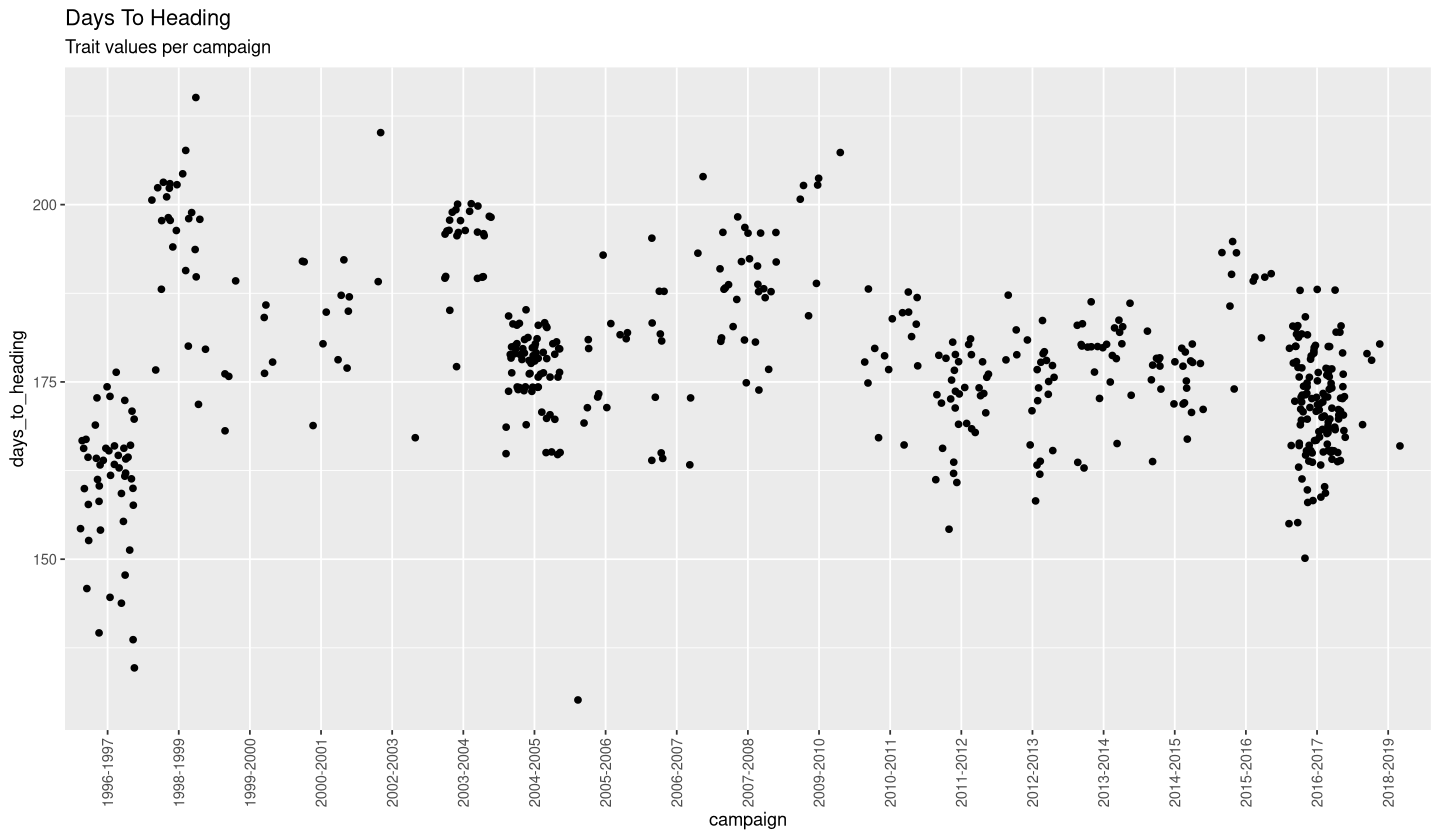

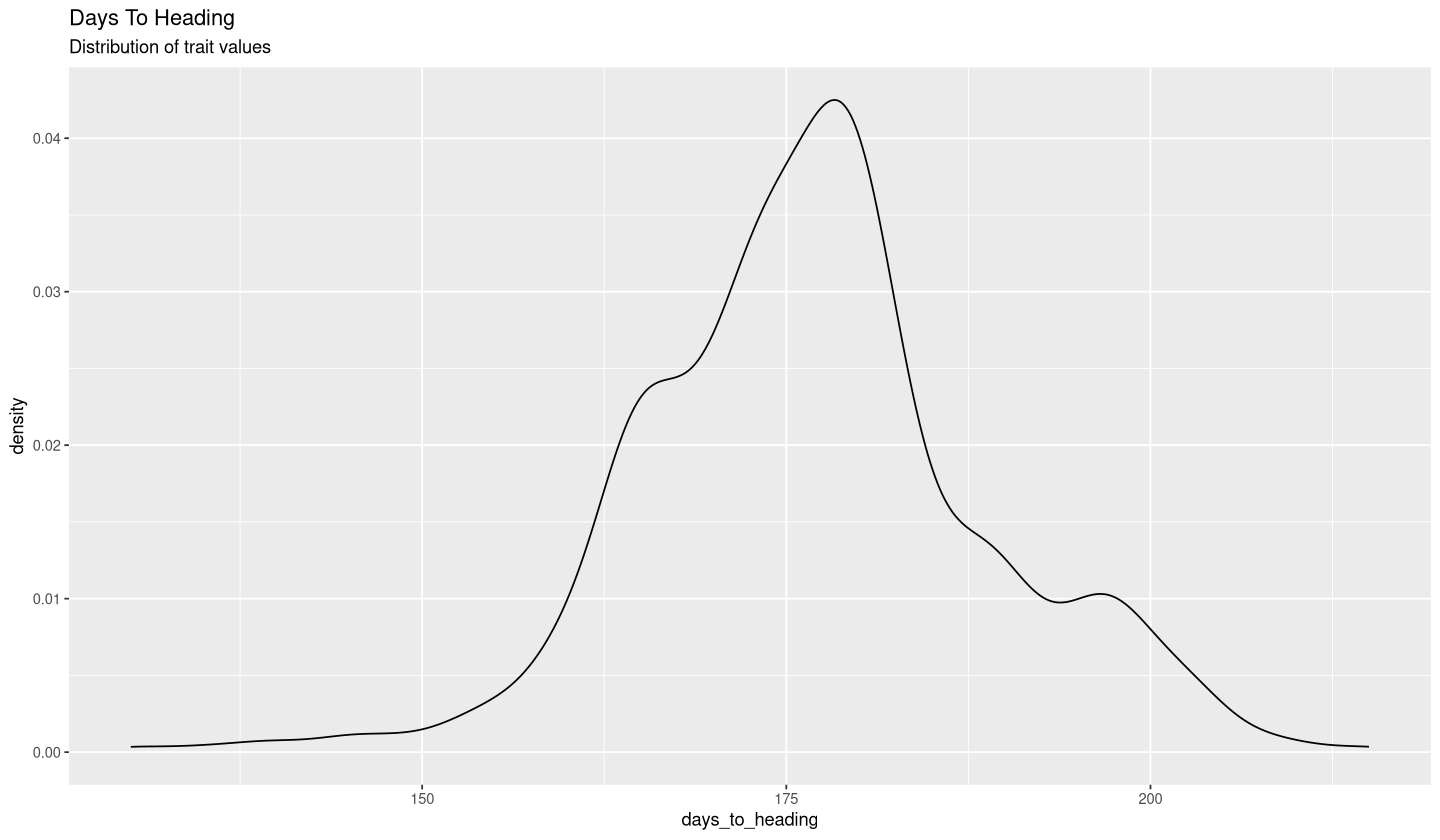

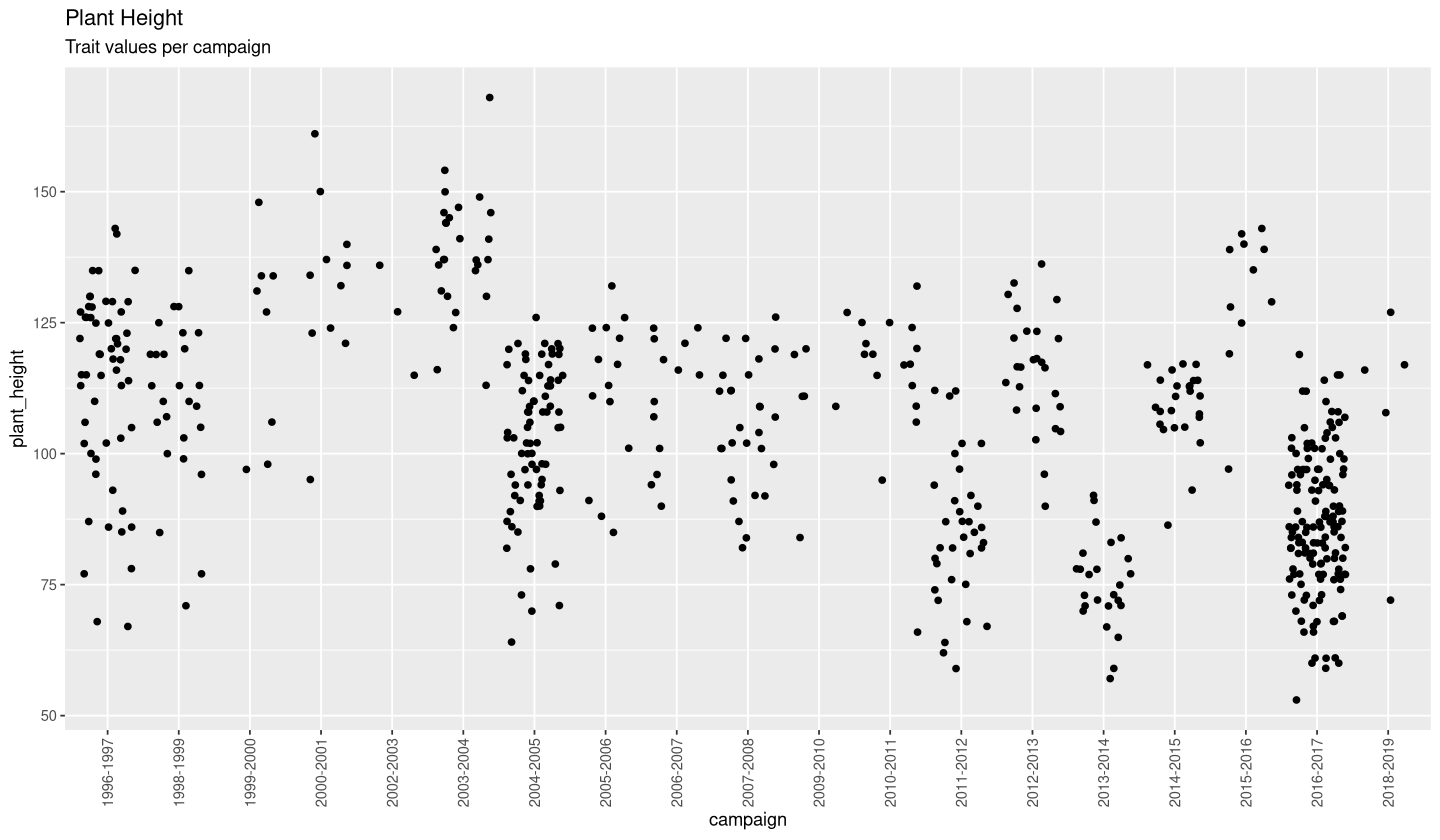

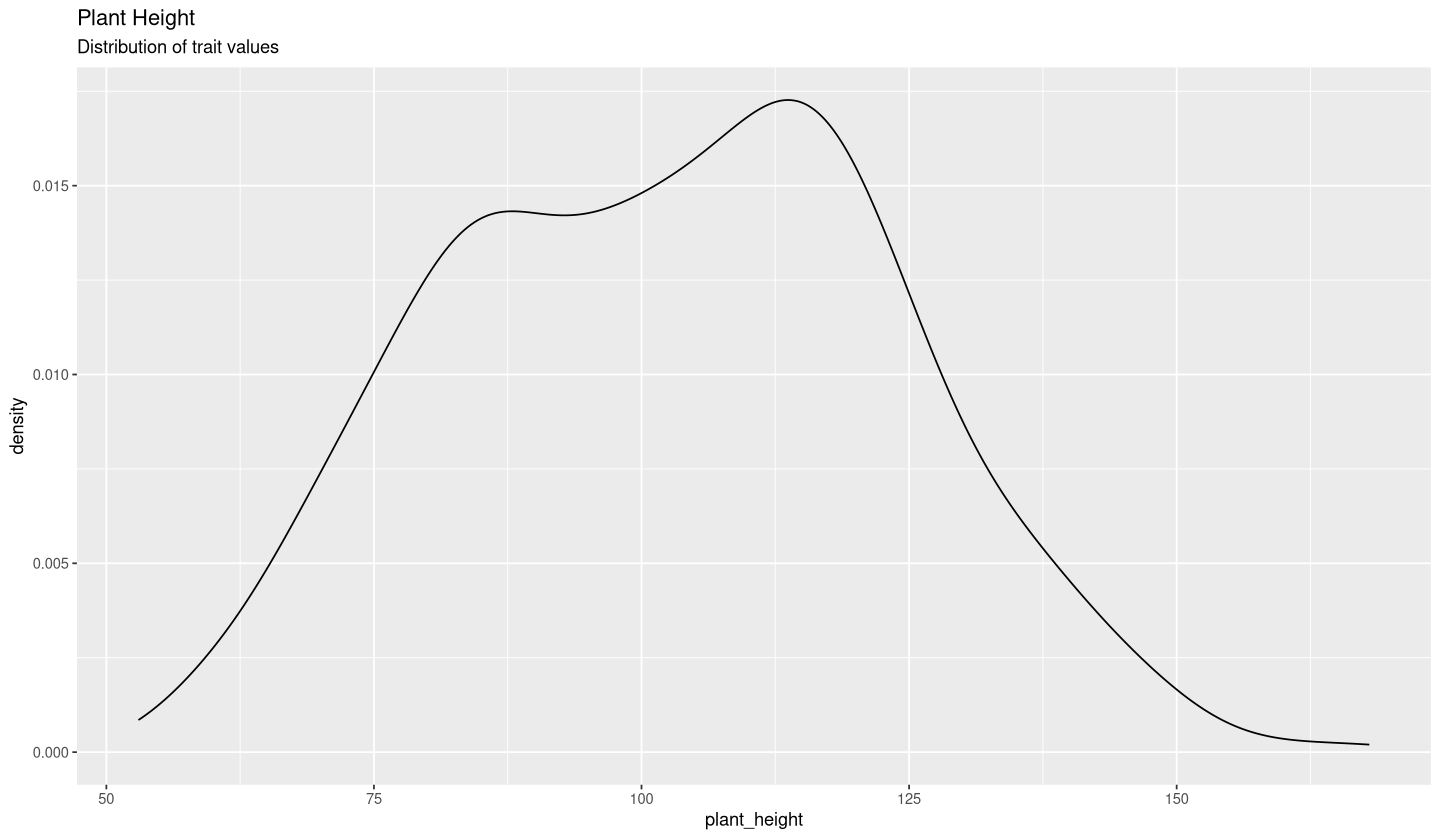

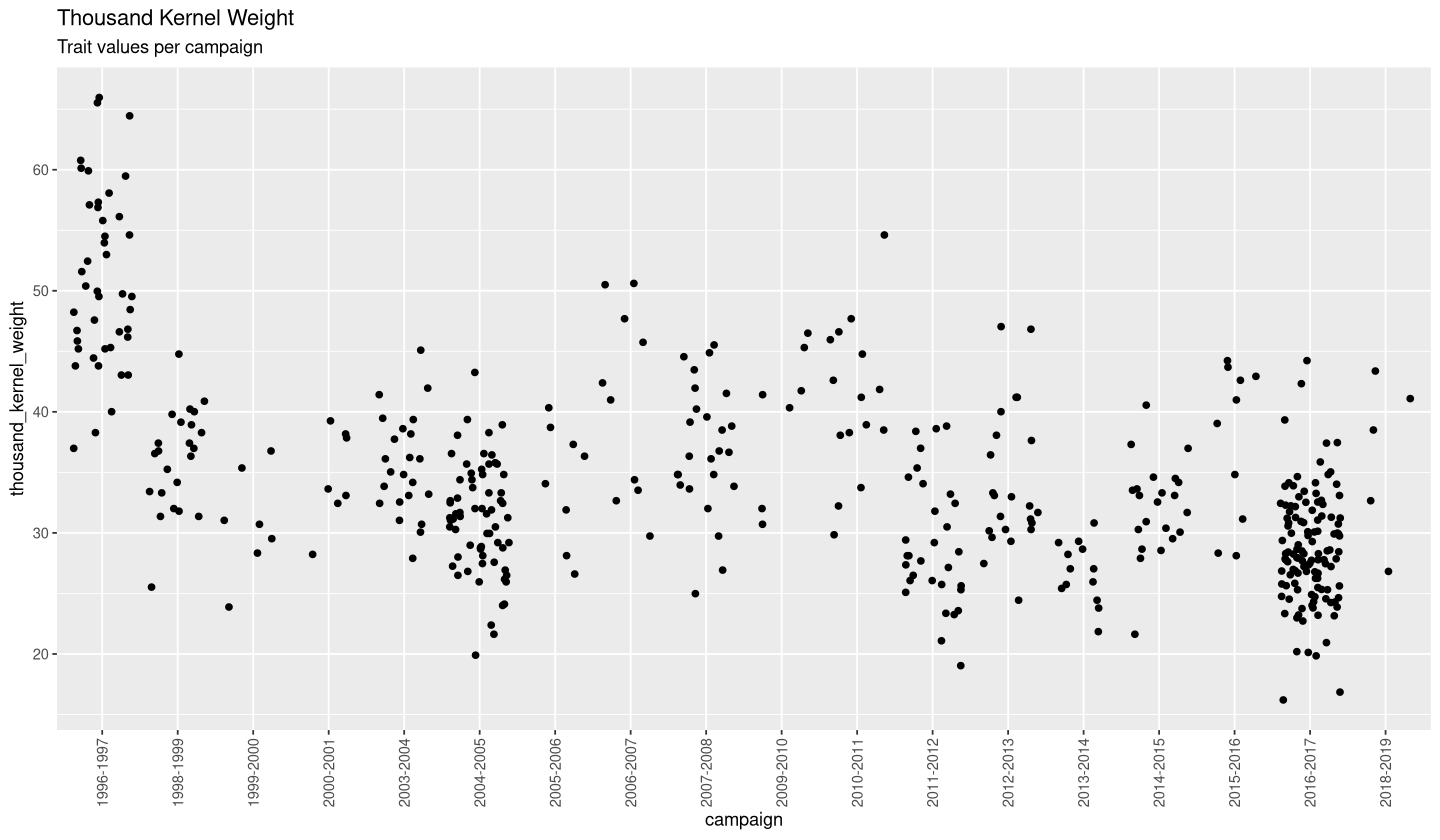

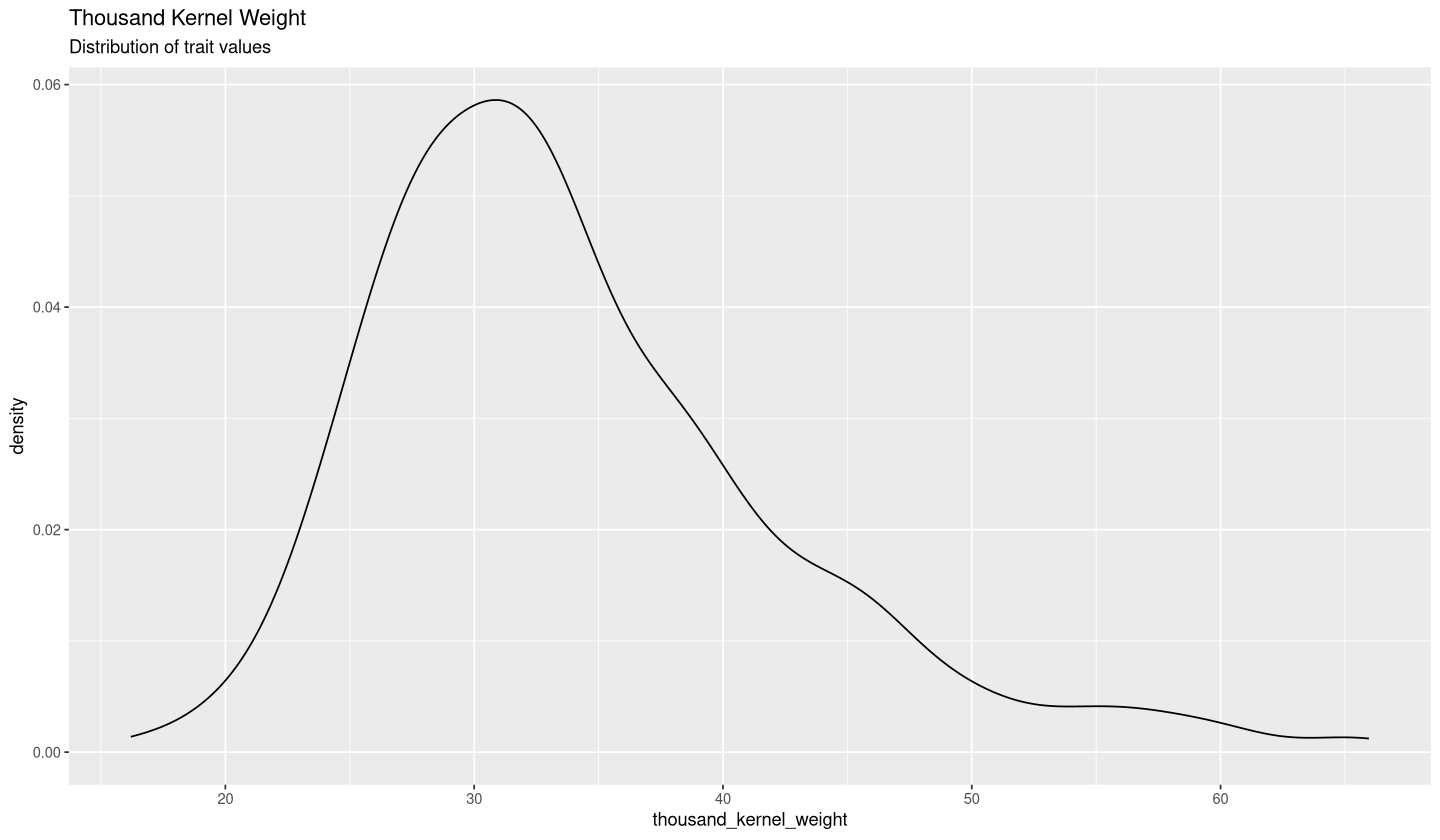

In [7]:
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [8]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

Online License checked out Mon Nov 20 12:43:10 2023
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:10 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1185.914           1.0    506 12:43:10    0.0 (2 restrained)
 2     -1146.098           1.0    506 12:43:10    0.0
 3     -1120.798           1.0    506 12:43:10    0.0 (1 restrained)
 4     -1112.105           1.0    506 12:43:10    0.0 (1 restrained)
 5     -1109.761           1.0    506 12:43:10    0.0 (1 restrained)
 6     -1109.609           1.0    506 12:43:10    0.0 (1 restrained)
 7     -1109.604           1.0    506 12:43:10    0.0


In [9]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:10 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1603.201           1.0    530 12:43:10    0.0
 2     -1590.878           1.0    530 12:43:10    0.0
 3     -1579.978           1.0    530 12:43:10    0.0
 4     -1575.359           1.0    530 12:43:10    0.0
 5     -1574.355           1.0    530 12:43:10    0.0
 6     -1574.315           1.0    530 12:43:10    0.0
 7     -1574.313           1.0    530 12:43:10    0.0


In [10]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:10 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -938.756           1.0    440 12:43:10    0.0
 2      -928.264           1.0    440 12:43:10    0.0
 3      -918.849           1.0    440 12:43:10    0.0 (1 restrained)
 4      -915.170           1.0    440 12:43:10    0.0 (1 restrained)
 5      -914.386           1.0    440 12:43:10    0.0 (1 restrained)
 6      -914.338           1.0    440 12:43:10    0.0 (1 restrained)
 7      -914.334           1.0    440 12:43:10    0.0


In [11]:
get_campaign_effect <- function(asreml_campaign){
                        intercept_index <- nrow(asreml_campaign$coeff$fixed)
                        intercept <- asreml_campaign$coeff$fixed[intercept_index]
                        campaign_effect <- asreml_campaign$coeff$fixed[-intercept_index,] + intercept
                        return(campaign_effect |> as.data.frame() |> rownames_to_column() |> 
                                mutate(campaign = str_sub(rowname,10)) |> 
                                select(campaign, campaign_effect))}

In [12]:
campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)

## Extract heterogeneous error variances

In [13]:
get_error_var <- function(asreml_campaign){
                    summary(asreml_campaign)$varcomp |> slice(2:n()) |> select(std.error) |> 
                    as_tibble() |> rename("error_variance"="std.error")}

In [14]:
error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_TKW <- get_error_var(asreml_campaign_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [15]:
make_CV_df <- function(campaign_effect, error_var){
                tibble(campaign_effect, error_var) |> 
                mutate(coefficient_of_variation=sqrt(error_variance)/campaign_effect) |> 
                mutate(standardized_CV=scale(coefficient_of_variation)[,1])}

In [16]:
CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)

## Remove outlier campaigns

In [17]:
correct_I <- function(data_sub, CV_df){
                        outlier_campaigns <- CV_df |> filter(standardized_CV > 3.5) |> select(campaign)
                        cat(nrow(outlier_campaigns), "outlier campaign(s) detected for trait", colnames(data_sub)[3])
                        if (nrow(outlier_campaigns) >= 1){cat(":", paste(outlier_campaigns$campaign), "\n")}
                        else{cat("\n")}
                        return(data_sub |> filter(! campaign %in% outlier_campaigns) |>
                               group_by(campaign) |> filter(n()>1) |> ungroup())}

In [18]:
data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)

1 outlier campaign(s) detected for trait days_to_heading: 2002-2003 
0 outlier campaign(s) detected for trait plant_height
0 outlier campaign(s) detected for trait thousand_kernel_weight


## Residuals

In [19]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:11 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -746.688           1.0    305 12:43:11    0.0 (3 restrained)
 2      -701.328           1.0    305 12:43:11    0.0
 3      -673.857           1.0    305 12:43:11    0.0
 4      -655.906           1.0    305 12:43:11    0.0
 5      -647.056           1.0    305 12:43:11    0.0
 6      -644.733           1.0    305 12:43:11    0.0
 7      -644.334           1.0    305 12:43:11    0.0
 8      -644.253           1.0    305 12:43:11    0.0 (1 restrained)
 9      -644.183           1.0    305 12:43:11    0.0 (1 restrained)
10      -644.171           1.0    305 12:43:11    0.0 (1 restrained)
11      -644.170           1.0    305 12:43:11    0.0 (1 restrained)


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


In [20]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:11 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1083.339           1.0    332 12:43:11    0.0
 2     -1062.627           1.0    332 12:43:11    0.0
 3     -1040.871           1.0    332 12:43:11    0.0
 4     -1026.731           1.0    332 12:43:11    0.0
 5     -1018.919           1.0    332 12:43:11    0.0
 6     -1016.528           1.0    332 12:43:11    0.0
 7     -1016.083           1.0    332 12:43:11    0.0
 8     -1016.016           1.0    332 12:43:11    0.0 (1 restrained)
 9     -1015.986           1.0    332 12:43:11    0.0 (1 restrained)
10     -1015.983           1.0    332 12:43:11    0.0 (1 restrained)
11     -1015.983           1.0    332 12:43:11    0.0 (1 restrained)


Warning message in asreml(fixed = plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [21]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:11 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -595.852           1.0    251 12:43:11    0.0
 2      -579.291           1.0    251 12:43:11    0.0 (1 restrained)
 3      -564.194           1.0    251 12:43:11    0.0 (1 restrained)
 4      -555.396           1.0    251 12:43:11    0.0 (1 restrained)
 5      -551.046           1.0    251 12:43:11    0.0 (2 restrained)
 6      -549.943           1.0    251 12:43:11    0.0 (2 restrained)
 7      -549.842           1.0    251 12:43:11    0.0 (1 restrained)
 8      -549.840           1.0    251 12:43:11    0.0 (1 restrained)
 9      -549.840           1.0    251 12:43:11    0.0


In [22]:
make_BH_multtest <- function(asreml_res){
            trait_title <- colnames(asreml_res$mf)[3] |> str_replace_all("_", " ") |> str_to_title()
            residual <- asreml_res$residuals
            MAD <- 1.4826*median(abs(residual-median(residual))) #approx constant https://en.wikipedia.org/wiki/Median_absolute_deviation#Relation_to_standard_deviation
            rawp_BHStud <- 2 * (1 - pnorm(abs(residual/MAD)))
            test_BHStud <- mt.rawp2adjp(rawp_BHStud, proc=c("Holm"))
            result_df <- tibble(adjp=test_BHStud[[1]][,1], bholm=test_BHStud[[1]][,2], index=test_BHStud[[2]]) |>
                    mutate(is_outlier = bholm < 0.05) |> arrange(index) |> mutate(std_residual = scale(residual)[,1])
            cat(sum(result_df$is_outlier), "outlier value(s) detected for trait", trait_title, "\n")
            plot(ggplot(result_df, aes(index,std_residual, color=is_outlier)) + geom_jitter()
                 + scale_colour_manual(values = c("TRUE" = "#A51D2D", "FALSE" = "#26A269"))
                 + labs(title = trait_title, subtitle = "Outlier detection with Bonferroni–Holm method"))
            return(result_df |> as.data.frame())}

17 outlier value(s) detected for trait Days To Heading 


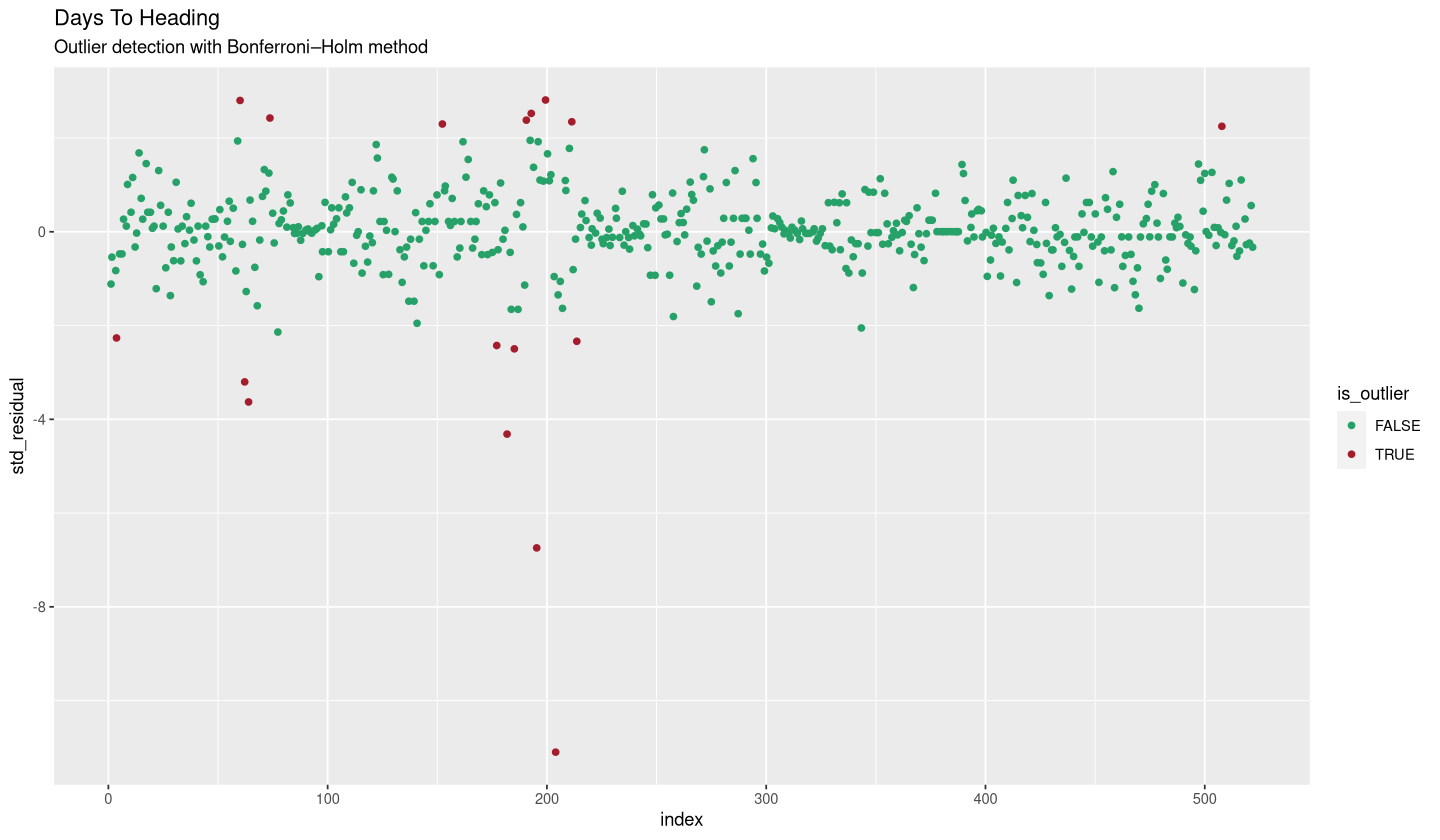

In [23]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

2 outlier value(s) detected for trait Plant Height 


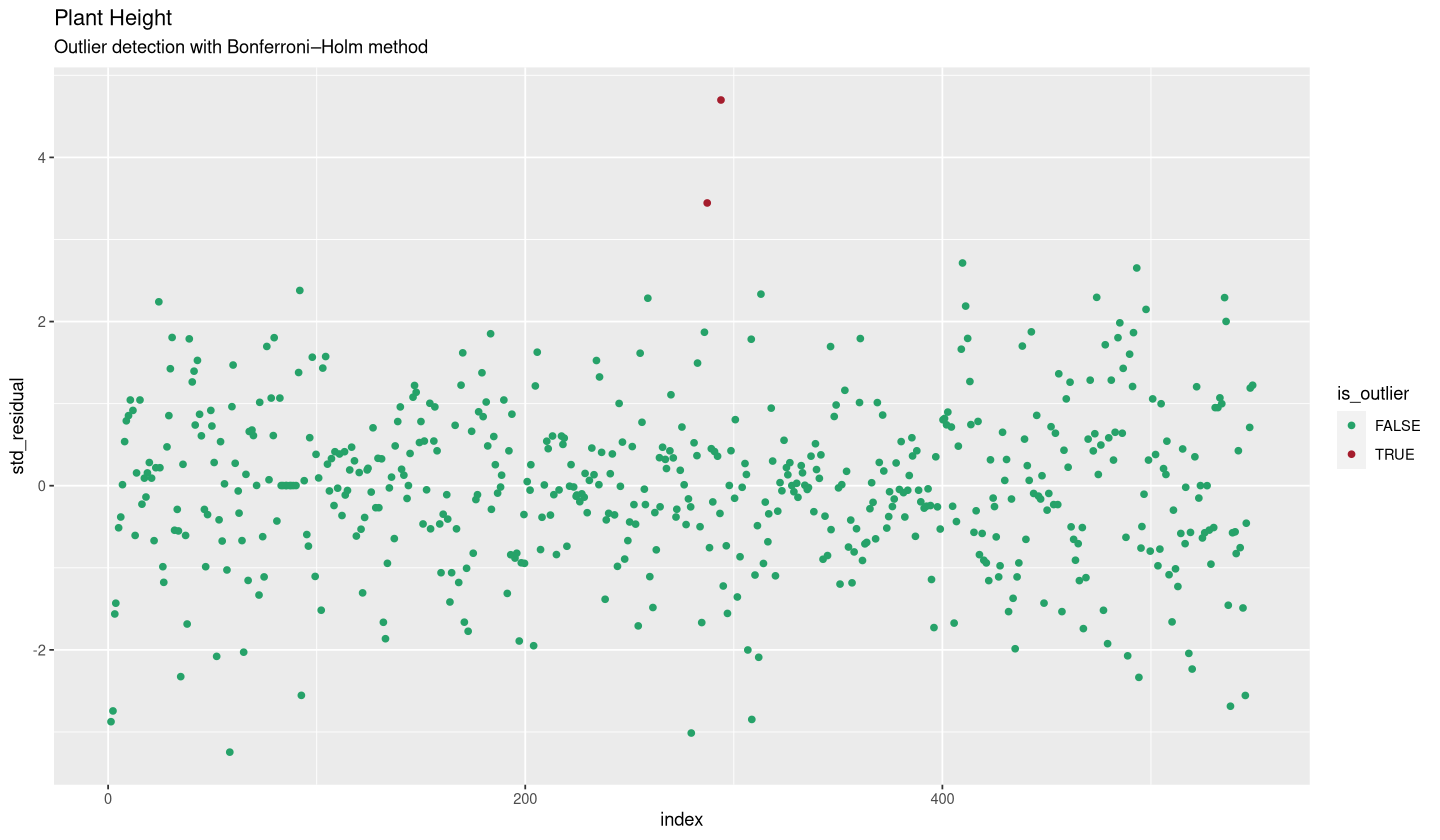

In [24]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

15 outlier value(s) detected for trait Thousand Kernel Weight 


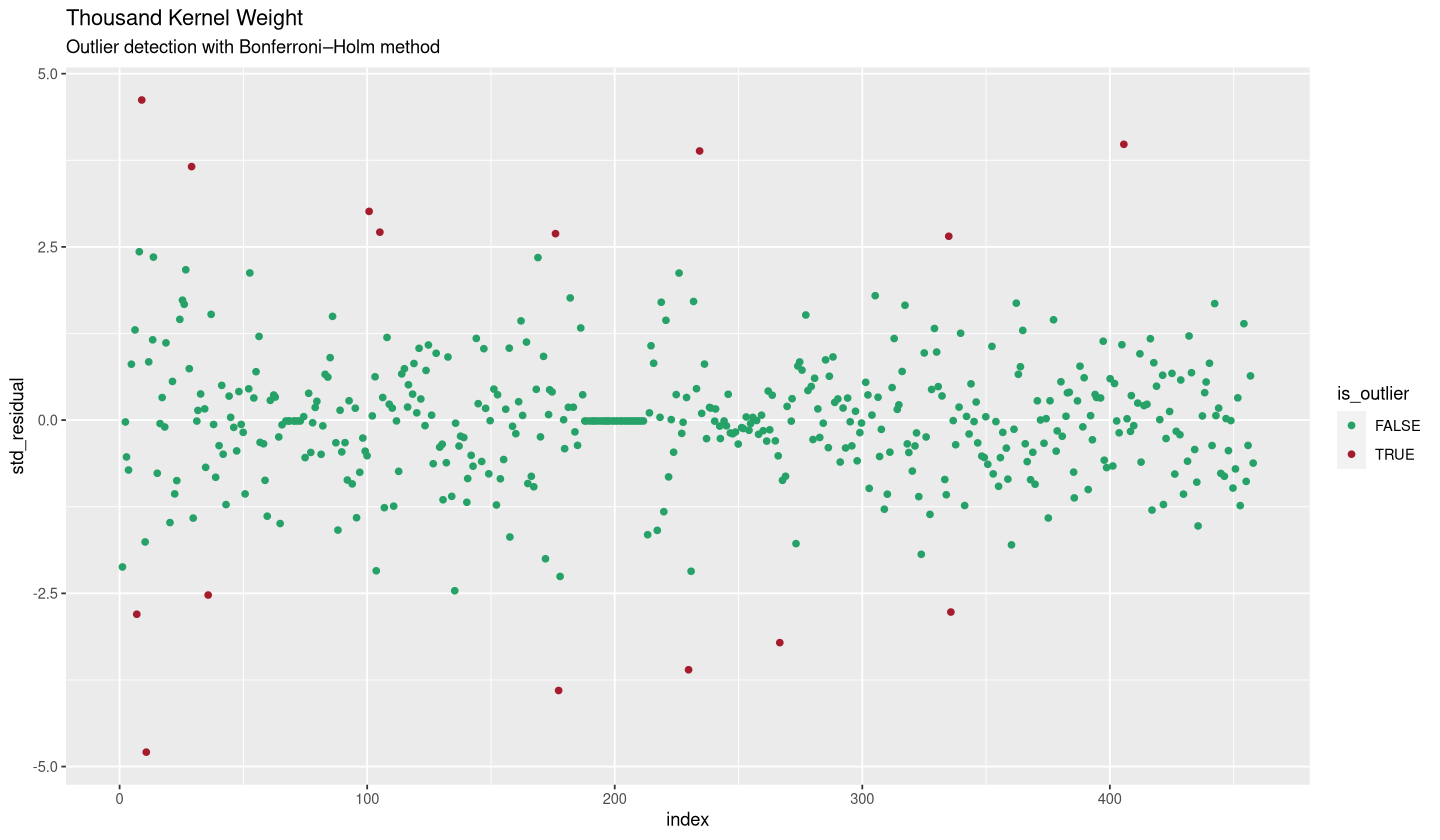

In [25]:
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)

In [26]:
correct_II <- function(data_corrected_I, result_BH){
                        data_corrected_I[result_BH[which(!result_BH$is_outlier),"index"],] |> 
                        group_by(accenumb) |> filter(n() > 1) |> group_by(campaign) |> filter(n() > 1) |> 
                        arrange(campaign, accenumb) |> as.data.frame() |> droplevels()}

In [27]:
data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)

## Calculate heritability

In [28]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:12 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1185.379           1.0    491 12:43:12    0.0 (3 restrained)
 2     -1116.535           1.0    491 12:43:12    0.0
 3     -1068.301           1.0    491 12:43:12    0.0 (1 restrained)
 4     -1041.422           1.0    491 12:43:12    0.0 (1 restrained)
 5     -1029.584           1.0    491 12:43:12    0.0 (1 restrained)
 6     -1026.663           1.0    491 12:43:12    0.0 (1 restrained)
 7     -1026.157           1.0    491 12:43:12    0.0 (1 restrained)
 8     -1026.128           1.0    491 12:43:12    0.0
 9     -1026.115           1.0    491 12:43:12    0.0


In [29]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:12 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1705.159           1.0    544 12:43:12    0.0
 2     -1674.998           1.0    544 12:43:12    0.0
 3     -1644.828           1.0    544 12:43:12    0.0
 4     -1627.071           1.0    544 12:43:12    0.0
 5     -1618.986           1.0    544 12:43:12    0.0
 6     -1616.866           1.0    544 12:43:12    0.0
 7     -1616.540           1.0    544 12:43:12    0.0
 8     -1616.526           1.0    544 12:43:12    0.0


In [30]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:12 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -942.727           1.0    434 12:43:12    0.0
 2      -916.989           1.0    434 12:43:12    0.0
 3      -891.664           1.0    434 12:43:12    0.0
 4      -877.189           1.0    434 12:43:12    0.0
 5      -870.986           1.0    434 12:43:12    0.0
 6      -869.657           1.0    434 12:43:12    0.0
 7      -869.494           1.0    434 12:43:12    0.0
 8      -869.476           1.0    434 12:43:12    0.0
 9      -869.471           1.0    434 12:43:12    0.0
10      -869.470           1.0    434 12:43:12    0.0


Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Some components changed by more than 1% on the last iteration.”


In [31]:
get_quality <- function(data_sub, asreml_res_h){
                trait <- colnames(data_sub)[3]
                varcomp <- summary(asreml_res_h)$varcomp
                var_G <- varcomp[2,"component"]
                var_E <- mean(varcomp[3:nrow(varcomp),"component"])
                no_campaigns <- mean(table(data_sub$accenumb[!is.na(data_sub[,trait])]))
                heritability <- var_G/(var_G+(var_E/no_campaigns))
                cat(colnames(data_sub)[3], "heritability:", round(heritability*100,1), "%\n")
                return(tibble(trait, heritability, var_G, var_E, no_campaigns))}

In [32]:
quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_TKW <- get_quality(data_sub_TKW, asreml_res_h_TKW)
quality_WW_all <- bind_rows(quality_HT, quality_PH, quality_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_WW_all,"INIA_wheat_data_quality.csv")

days_to_heading heritability: 89.3 %
plant_height heritability: 65.9 %
thousand_kernel_weight heritability: 72.6 %


## Run linear mixed model with outlier corrected data

In [33]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:13 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -676.870           1.0    289 12:43:13    0.0 (5 restrained)
 2      -621.096           1.0    289 12:43:13    0.0
 3      -589.267           1.0    289 12:43:13    0.0
 4      -568.369           1.0    289 12:43:13    0.0
 5      -558.315           1.0    289 12:43:13    0.0
 6      -555.423           1.0    289 12:43:13    0.0
 7      -555.087           1.0    289 12:43:13    0.0
 8      -554.931           1.0    289 12:43:13    0.0
 9      -554.896           1.0    289 12:43:13    0.0
10      -554.892           1.0    289 12:43:13    0.0
11      -554.890           1.0    289 12:43:13    0.0
12      -554.890           1.0    289 12:43:13    0.0


Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [34]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:13 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1072.441           1.0    330 12:43:13    0.0 (1 restrained)
 2     -1048.154           1.0    330 12:43:13    0.0
 3     -1027.338           1.0    330 12:43:13    0.0
 4     -1013.365           1.0    330 12:43:13    0.0
 5     -1005.458           1.0    330 12:43:13    0.0
 6     -1003.003           1.0    330 12:43:13    0.0
 7     -1002.543           1.0    330 12:43:13    0.0
 8     -1002.486           1.0    330 12:43:13    0.0 (1 restrained)
 9     -1002.445           1.0    330 12:43:13    0.0 (1 restrained)
10     -1002.440           1.0    330 12:43:13    0.0 (1 restrained)
11     -1002.440           1.0    330 12:43:13    0.0 (1 restrained)


Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [35]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Nov 20 12:43:13 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -523.299           1.0    237 12:43:13    0.0 (2 restrained)
 2      -501.133           1.0    237 12:43:13    0.0 (2 restrained)
 3      -485.992           1.0    237 12:43:13    0.0 (3 restrained)
 4      -476.814           1.0    237 12:43:13    0.0 (3 restrained)
 5      -473.065           1.0    237 12:43:13    0.0 (2 restrained)
 6      -470.860           1.0    237 12:43:13    0.0 (2 restrained)
 7      -469.862           1.0    237 12:43:13    0.0 (2 restrained)
 8      -469.738           1.0    237 12:43:13    0.0 (2 restrained)
 9      -469.684           1.0    237 12:43:13    0.0 (1 restrained)
10      -469.389           1.0    237 12:43:13    0.0 (2 restrained)
11      -470.635           1.0    237 12:43:13    0.0 (1 restrained)
12      -470.032           1.0    237 12:43:13    0.0 (1 restrained)
13      -469.594          

Warning message in asreml(thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”
Warning message in asreml(thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


## Extract BLUEs and create output file

In [36]:
get_BLUEs <- function(asreml_data){
                            trait <- colnames(asreml_data$mf)[3]
                            intercept_index <- nrow(asreml_data$coeff$fixed)
                            intercept <- asreml_data$coeff$fixed[intercept_index]
                            BLUE <- asreml_data$coeff$fixed[-intercept_index,] + intercept
                            return(BLUE |> as.data.frame() |>
                                    rownames_to_column() |>
                                    mutate(genotype=str_split_i(rowname,"_", -1)) |> #assuming there is no underscore in the accession numbers
                                    select(genotype, BLUE) |> rename_with(~paste(trait, .x, sep="_"), 2))}

In [37]:
BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)
BLUEs_TKW <- get_BLUEs(asreml_data_TKW)

BLUE_WW_all <- genotypes |> 
                        left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_WW_all,"INIA_wheat_BLUE_values.csv")
summary(BLUE_WW_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:1260        Min.   :160.3        Min.   : 71.47   
 Class :character   1st Qu.:178.0        1st Qu.:108.47   
 Mode  :character   Median :182.4        Median :114.34   
                    Mean   :181.4        Mean   :113.95   
                    3rd Qu.:186.0        3rd Qu.:121.12   
                    Max.   :195.9        Max.   :141.35   
                    NA's   :1057         NA's   :1045     
 thousand_kernel_weight_BLUE
 Min.   :17.93              
 1st Qu.:33.23              
 Median :36.39              
 Mean   :35.87              
 3rd Qu.:39.51              
 Max.   :51.02              
 NA's   :1062               

In [38]:
library(rmarkdown)
convert_ipynb("INIA_historic_wheat_data_analysis.ipynb")

In [39]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: FlexiBLAS OPENBLAS-OPENMP;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.25      asreml_4.1.0.154    Matrix_1.6-3       
 [4] multtest_2.56.0     Biobase_2.60.0      BiocGenerics_0.46.0
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_